In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

## Loading data

In [2]:
def load_daily_site_prod(site, daily_prod):
    daily_site_prod = []
    input_folder = '../data/input/daily_production/'
    file_path = os.path.join(input_folder, site)
    
    # Iterate through each file in the directory
    for filename in os.listdir(file_path):
        if filename.endswith('.json'):
            full_path = os.path.join(file_path, filename)
            # Read JSON file into a dictionary
            with open(full_path, 'r') as file:
                json_data = json.load(file)
            # Append dictionary to the list
            daily_site_prod.append(json_data)

    # convert list (of dictionaries) to dataframe
    site_data = pd.DataFrame(daily_site_prod)
    # Add site info to records
    site_data['site'] = site

    daily_prod = pd.concat([daily_prod, site_data])
    return daily_prod

# Load master_data.json
master_data = '../data/input/master_data.json'
# Read JSON file into a dictionary
with open(master_data, 'r') as file:
    master_data_file = json.load(file)

# Load site data
sites = ['BRU', 'STO']
daily_prod = pd.DataFrame()
for site in sites:
    daily_prod = load_daily_site_prod(site, daily_prod)
    
daily_prod.info()
daily_prod.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3660 entries, 0 to 1829
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DoW             3660 non-null   object
 1   hour            3660 non-null   int64 
 2   minute          3660 non-null   int64 
 3   date            3660 non-null   object
 4   maintenance     3660 non-null   object
 5   prod_loss       3660 non-null   object
 6   prod_loss_perc  3660 non-null   object
 7   production      3660 non-null   object
 8   site            3660 non-null   object
dtypes: int64(2), object(7)
memory usage: 285.9+ KB


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,site
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,225,18,1019,BRU
1,Monday,1,0,01-22-2018 00:00:00.0000,No,255,20,989,BRU
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,138,11,1106,BRU
3,Tuesday,1,0,08-21-2018 00:00:00.0000,No,302,24,942,BRU
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,211,17,1033,BRU


## Preprocessing data

In [3]:
def preprocess(df):
    # exclude maintenance days
    df = df[df['maintenance'] == 'No']
    
    df = df.copy()
    df.date = pd.to_datetime(df.date)
    df.prod_loss_perc = df.prod_loss_perc.astype(int)
    df.prod_loss = df.prod_loss.astype(int)
    df.production = df.production.astype(int)
    return df

# clean & filter data
daily_prod_excl_maint = preprocess(daily_prod)

daily_prod_excl_maint.info()
daily_prod_excl_maint.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3452 entries, 0 to 1828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DoW             3452 non-null   object        
 1   hour            3452 non-null   int64         
 2   minute          3452 non-null   int64         
 3   date            3452 non-null   datetime64[ns]
 4   maintenance     3452 non-null   object        
 5   prod_loss       3452 non-null   int64         
 6   prod_loss_perc  3452 non-null   int64         
 7   production      3452 non-null   int64         
 8   site            3452 non-null   object        
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 269.7+ KB


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,site
0,Tuesday,1,0,2020-09-22,No,225,18,1019,BRU
1,Monday,1,0,2018-01-22,No,255,20,989,BRU
2,Wednesday,1,0,2019-08-21,No,138,11,1106,BRU
3,Tuesday,1,0,2018-08-21,No,302,24,942,BRU
4,Wednesday,1,0,2021-09-22,No,211,17,1033,BRU


## Exploratory Data Analysis

### Explore maintenance

In [92]:
# Calculate percentage maintenance
prod_per_site = daily_prod.groupby('site')['maintenance'].value_counts()
print(prod_per_site)

# Calculate percentage maintenance per site
maintenance_counts = prod_per_site
total_days_per_site = daily_prod.groupby('site').size()
maintenance_perc_per_site = (maintenance_counts / total_days_per_site) * 100

prob_maint_bru = maintenance_perc_per_site.get(('BRU', 'Yes'), 0)
prob_maint_sto = maintenance_perc_per_site.get(('STO', 'Yes'), 0)

print()
print(f'Percentage of maintenance days in BRU: {prob_maint_bru:.2f}%')
print(f'Percentage of maintenance days in STO: {prob_maint_sto:.2f}%')

site  maintenance
BRU   No             1736
      Yes              94
STO   No             1716
      Yes             114
Name: count, dtype: int64

Percentage of maintenance days in BRU: 5.14%
Percentage of maintenance days in STO: 6.23%


### Explore the probability for days with 0 production (on no-maintenance days)

In [93]:
# Calculate the number of zero production days for each site
zero_prod_counts_per_site = daily_prod_excl_maint[daily_prod_excl_maint['production'] == 0].groupby('site').size()
print("Zero production days per site (excl maintenance days)")
print(zero_prod_counts_per_site)

# Calculate the total number of days for each site
total_days_per_site = daily_prod_excl_maint.groupby('site').size()

# Calculate the probability of zero production for each site
prob_zero_prod_per_site = zero_prod_counts_per_site / total_days_per_site * 100

# Extract probabilities for each site into variables
prob_zero_prod_bru = prob_zero_prod_per_site.get('BRU', 0)
prob_zero_prod_sto = prob_zero_prod_per_site.get('STO', 0)

# Print the probabilities
print()
print(f"Probability of zero production day for BRU: {prob_zero_prod_bru:.2f}%")
print(f"Probability of zero production day for STO: {prob_zero_prod_sto:.2f}%")


Zero production days per site (excl maintenance days)
site
BRU    308
STO    126
dtype: int64

Probability of zero production day for BRU: 17.74%
Probability of zero production day for STO: 7.34%


### Explore distribution of production on DaysOfWeek

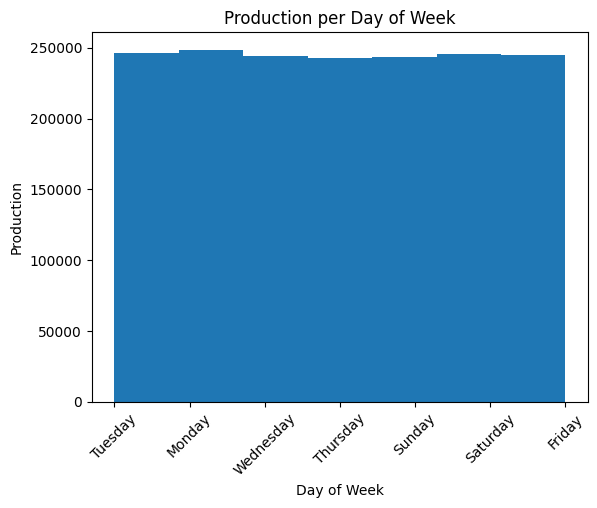

In [6]:
daily_prod_excl_maint['DoW'] = pd.Categorical(daily_prod_excl_maint['DoW'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Plot
plt.hist(daily_prod_excl_maint['DoW'], weights=daily_prod_excl_maint['production'], bins=7, alpha=1)
plt.title('Production per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Production')
plt.xticks(rotation=45)
plt.show()

In [7]:
master_data_file

{'BRU msr': 1244, 'STO msr': 274}

### Visualize production distribution

<Axes: >

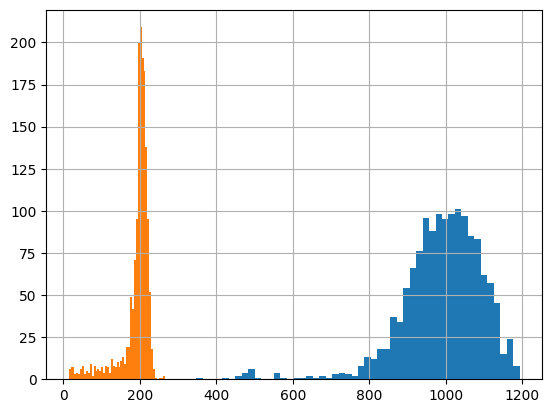

In [4]:
# Visualize distribution of production on sites

daily_prod_bru = daily_prod_excl_maint[(daily_prod_excl_maint['site'] == 'BRU') & (daily_prod_excl_maint.production != 0)]
daily_prod_bru['production'].hist(bins=50)

daily_prod_sto = daily_prod_excl_maint[(daily_prod_excl_maint['site'] == 'STO') & (daily_prod_excl_maint.production != 0)]
daily_prod_sto['production'].hist(bins=50)

989.218487394958
108.94605568678298


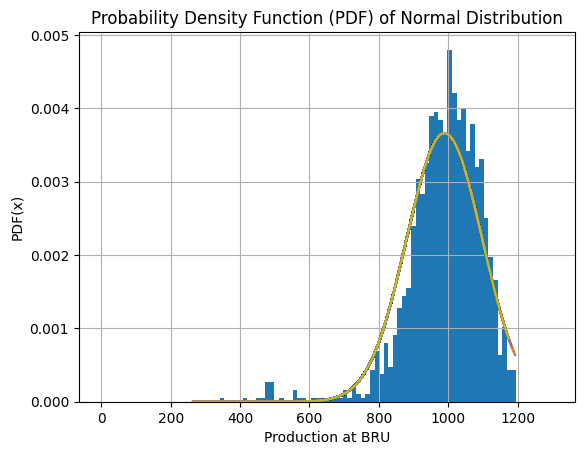

In [84]:
# Calculate PDF of distribution at BRU

daily_prod_bru['production'].hist(bins=np.linspace(0, 1300, 100), density = True)

# Define PDF parameters
mean = daily_prod_bru['production'].mean()
std_dev = daily_prod_bru['production'].std()

print(mean)
print(std_dev)

# Generate values that fit my data
x_values = np.linspace(daily_prod_bru['production'], np.max(daily_prod_sto['production']), 1000)

# Calculate PDF
pdf_values = stats.norm.pdf(x_values, loc=mean, scale=std_dev)

# Plot the PDF
plt.plot(x_values, pdf_values)
plt.title('Probability Density Function (PDF) of Normal Distribution')
plt.xlabel('Production at BRU')
plt.ylabel('PDF(x)')
plt.grid(True)
plt.show()

190.9679245283019
40.19051048298478


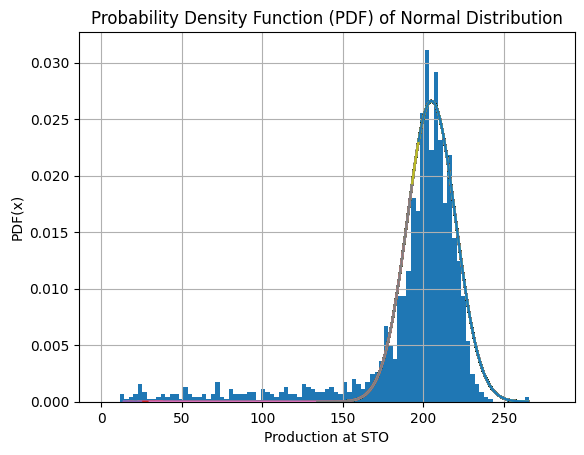

In [88]:
# Calculate PDF of distribution at STO

daily_prod_sto['production'].hist(bins=np.linspace(0, 280, 100), density = True)

# Define PDF parameters
mean = daily_prod_sto['production'].mean()
std_dev = daily_prod_sto['production'].std()

print(mean)
print(std_dev)

# Generate values that fit my data
x_values = np.linspace(daily_prod_sto['production'], np.max(daily_prod_sto['production']), 1000)

# Calculate PDF
pdf_values = stats.norm.pdf(x_values, loc=205, scale=15)

# Plot the PDF
plt.plot(x_values, pdf_values)
plt.title('Probability Density Function (PDF) of Normal Distribution')
plt.xlabel('Production at STO')
plt.ylabel('PDF(x)')
plt.grid(True)
plt.show()

Adjusted the mean & std to better fit the actual distribution

mean = 205 (instead of 190)
std_dev = 15 (instead of 40)

daily_prod_sto[daily_prod_sto['production'] > 160]

In [91]:
daily_prod_sto[daily_prod_sto['production'] < 150].shape[0] / daily_prod_sto[daily_prod_sto['production'] >= 150].shape[0]

0.11578947368421053

## Modeling production capability

### Calculate probability of productive days taking into account maintenance and 0 production days

In [95]:
# Define parameters
num_days = 100  # Number of days to simulate
prob_no_maint_bru = 1 - (prob_maint_bru / 100)
prob_no_zero_prod_bru = 1 - (prob_zero_prod_bru / 100)

# Calculate probability of no maintenance with non-zero production days
prob_no_maint_no_zero_prod_bru = prob_no_maint_bru * prob_no_zero_prod_bru

# Simulate production
no_maint_no_zero_prod_days = stats.binom.rvs(1, prob_no_maint_no_zero_prod_bru, size=num_days)

# Print simulated production data for each day
print(f'The probability of days with  more than 0 production is: {prob_no_maint_no_zero_prod_bru:.2f}%')
print()
print(f'A potential distribution of {num_days} production days taking into account zero production-days and maintenance on site BRU: ')
print()
print(no_maint_no_zero_prod_days)

The probability of days with  more than 0 production is: 0.78%

A potential distribution of 100 production days taking into account zero production-days and maintenance on site BRU: 

[0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0]


### Simulate production for x days

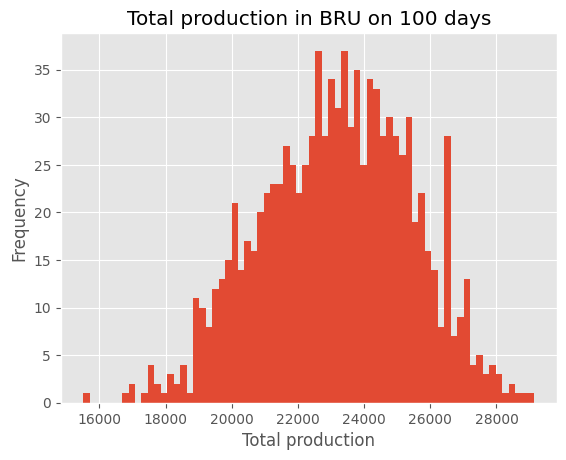

In [133]:
def production_simulation(num_days, num_simulations):
    simulated_data = []
    for sim in range(num_simulations):
        production_data = []
        
        # simulate maintenance, 0 prod and >0 prod days
        no_maint_no_zero_prod_days = stats.binom.rvs(1, prob_no_maint_no_zero_prod_bru, size=num_days)
        
        for day in no_maint_no_zero_prod_days:
            if day == 0:
                production_data.append(0)
            else:
                daily_production = np.random.normal(daily_prod_bru['production'].mean(), daily_prod_bru['production'].std())
                production_data.append(int(daily_production))
                
        simulated_data.append(production_data)
    return simulated_data

my_simulation = production_simulation(30, 10**3)

plt.style.use('ggplot')

# Calculate total production for each simulation
simulations_total_prod = []
for row in my_simulation:
    prod_per_numdays = np.sum(row)
    simulations_total_prod.append(prod_per_numdays)

plt.hist(simulations_total_prod, bins=70)
plt.xlabel('Total production')
plt.ylabel('Frequency')
plt.title(f'Total production in BRU on {num_days} days')

# Show plot
plt.grid(True)
plt.show()

